In [2]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as st
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten

We implement a function that filters the event times in process i that happens before event time T in process i.

In [3]:
def prev_event(times, T):
    """
    Return the event times in process i that happens before event time T in process i.
    : param times: an n-dimensional array, the full event times in process i
    : param T: a number, one event time in process i
    
    : return k: a number, the index of the last event time in process i happened before T in process i
    """
    
    return np.searchsorted(times, T, side='right')

We implement the compensator function.

In [4]:
def hawkes_comp(t, times, beta, theta, lambda_b):
    ratio = beta/theta
    ind = prev_event(times, t)
    second_sum = 0
    
    if ind != 0:
        second_sum = ratio * np.sum(np.exp(-theta*(t - times[0:ind])) - 1)
    comp= lambda_b*t - second_sum 
    
    return comp

And we implement the log likelihood function. 

In [6]:
def hawkes_log_likelihood(times, beta, theta, lambda_b): 
    ratio = beta/theta
    A = np.zeros(len(times))
    T = times[-1]
    
    for i in range(1, len(times)):
        A[i] = np.exp(-theta*(times[i] - times[i-1]))*(1+A[i-1])
    
    first_sum = np.sum(np.log(lambda_b + beta*A))
    second_sum = ratio * np.sum(np.exp(-theta*(T - times)) - 1)
    res = first_sum + second_sum - lambda_b*T
    
    return res

And we test the log likelihood function using the following.

In [7]:
def hawkes_log_likelihood2(t, beta, theta, lambda_b): 
    ratio = beta/theta
    A = np.zeros(len(t))
    T = t[-1]
    
    for i in range(1, len(t)):
        A[i] = np.exp(-theta*(t[i] - t[i-1]))*(1+A[i-1])
    
    first_sum = np.log(lambda_b + beta*A)
    second_sum = ratio * np.sum(np.exp(-theta*(T - t)) - 1)
    res = first_sum + second_sum - lambda_b*T
    
    return first_sum, second_sum, lambda_b*T

In [8]:
def hawkes_log_likelihood3(t, beta, theta, lambda_p): 
    ratio = beta/theta
    A = []
    for i in range(0, len(t)):
        if i==0:
            A.append(0)
        else:
            A.append(np.exp(-1*theta*(t[i] - t[i-1]))*(1+A[i-1]))
    A = np.array(A)
    first_sum = np.sum(np.log(lambda_p + beta*A))
    tk = t[-1]
    second_sum = ratio * np.sum(np.exp(-theta*(tk - t)) - 1)
    ret = first_sum + second_sum - lambda_p*tk
    return ret

The test

In [9]:
##rng = np.random.default_rng()
##t = np.sort(rng.choice(1000, 100, replace=False))
beta = 2.0
theta = 3.0
lambda_b = 1.0
##noise = np.random.uniform(0.0, 1.0, 3)
times = np.sort(np.random.uniform(0,75,size=3)) ##t.astype('float64') + noise

sum_1 = []
sum_1.append(np.log(lambda_b))
sum_1.append(np.log(lambda_b + beta*np.exp(-theta*(times[1] -times[0]))))
sum_1.append(np.log(lambda_b + beta*np.exp(-theta*(times[2] -times[0]))+ beta*np.exp(-theta*(times[2] -times[1]))))

sum_2 = 0.0
for i in range(3):
    sum_2 += np.exp(-theta*(times[-1]-times[i]))-1

l = np.sum(sum_1) - lambda_b * times[-1] + beta/theta*sum_2

u = hawkes_log_likelihood3(times, beta, theta, lambda_b)
sum1, sum2, sum3 = hawkes_log_likelihood2(times, beta, theta, lambda_b)
comp = hawkes_comp(times[-1], times, beta, theta, lambda_b)
print(np.abs(l -hawkes_log_likelihood(times, beta, theta, lambda_b)));
print(np.sum(sum1) - comp - hawkes_log_likelihood(times, beta, theta, lambda_b))

0.0
0.0


print(u[0] - sum_1, 
u[1] - beta/theta*sum_2, 
u[2] - lambda_b * t[-1])

We read the processed bike data folder for station 261, create a dictionary, store the file name as key and the data frame inside the file as value.

In [10]:
path = './dep/Station261'
data_files = os.listdir(path)
n_weeks = len(data_files)
bike_data = {file: pd.read_csv(path + '/' + file)
             for file in data_files}        

for names in bike_data.keys():
    del bike_data[names]["Unnamed: 0"]
    
bike_data.keys()

dict_keys(['235_07Oct2020-13Oct2020.csv', '234_30Sep2020-06Oct2020.csv', '222_08Jul2020-14Jul2020.csv', '227_12Aug2020-18Aug2020.csv', '224_22Jul2020-28Jul2020.csv', '226_05Aug2020-11Aug2020.csv', '232_16Sep2020-22Sep2020.csv', '228_19Aug2020-25Aug2020.csv', '236_14Oct2020-20Oct2020.csv', '221_01Jul2020-07Jul2020.csv', '231_09Sep2020-15Sep2020.csv', '225_29Jul2020-04Aug2020.csv', '223_15Jul2020-21Jul2020.csv', '233_23Sep2020-29Sep2020.csv', '230_02Sep2020-08Sep2020.csv', '229_26Aug2020-01Sep2020.csv'])

We extract the start time column, the departure times at station. We need to get away from the file '.DS_Store'.

In [11]:
dep_times = {}

for names in bike_data.keys():
    if names != '.DS_Store':
        df = bike_data[names]
        df = df['start_t']
        dep_times[names] = df.values.tolist()
 
dep_times_list = np.array(sorted(flatten(list(dep_times.values()))))
dep_times_list

array([788171.00969237, 788181.87341683, 788187.75415357, ...,
       948749.7261913 , 948751.98261002, 948869.33013766])

We test the model on data.

In [12]:
t0 = dep_times_list
hawkes_log_likelihood(t0, 2, 1, 1)

-953443.3219390939

We then perform the optimisation.

In [15]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle = op.minimize(op_hawkes_log_likelihood, x0 = [-5, -31, -13], method = 'Nelder-Mead', args=(t0,))
mle

 final_simplex: (array([[ -5.05040943, -31.23486158, -13.1623542 ],
       [ -5.05040946, -31.23477242, -13.16235255],
       [ -5.05040947, -31.23490125, -13.16235489],
       [ -5.05040938, -31.23495794, -13.16235336]]), array([12406.12336532, 12406.12336532, 12406.12336532, 12406.12336532]))
           fun: 12406.123365316076
       message: 'Optimization terminated successfully.'
          nfev: 134
           nit: 72
        status: 0
       success: True
             x: array([ -5.05040943, -31.23486158, -13.1623542 ])

We also want to find the p values.

In [2]:
beta, theta, lambda_b = np.exp(mle.x[0]), np.exp(mle.x[0]) + np.exp(mle.x[1]), np.exp(mle.x[2])

compensator_t = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t[i+1] = hawkes_comp(t0[i], t0, beta, theta, lambda_b)

inter_arr_times = np.diff(compensator_t)
p_values = np.exp(-inter_arr_times)

NameError: name 'np' is not defined

And we plot the empirical CDF.

In [17]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    data = np.sort(data)
    n = data.size
    y = np.arange(1, n+1) / n
    return(data,y)

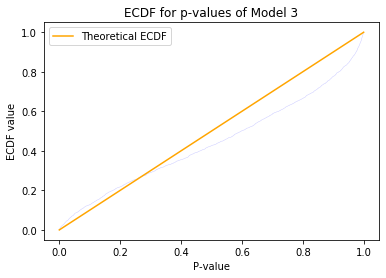

In [18]:
x,y = ecdf(p_values)
plt.plot(x,y, alpha=0.2, linewidth=0.5, color='blue')

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We now perform the above on a different bike station.

In [41]:
path = './dep/Station151'
data_files = os.listdir(path)
n_weeks = len(data_files)
bike_data = {file: pd.read_csv(path + '/' + file)
             for file in data_files}        

for names in bike_data.keys():
    del bike_data[names]["Unnamed: 0"]
    
bike_data.keys()

dict_keys(['235_07Oct2020-13Oct2020.csv', '234_30Sep2020-06Oct2020.csv', '222_08Jul2020-14Jul2020.csv', '227_12Aug2020-18Aug2020.csv', '224_22Jul2020-28Jul2020.csv', '226_05Aug2020-11Aug2020.csv', '232_16Sep2020-22Sep2020.csv', '228_19Aug2020-25Aug2020.csv', '236_14Oct2020-20Oct2020.csv', '221_01Jul2020-07Jul2020.csv', '231_09Sep2020-15Sep2020.csv', '225_29Jul2020-04Aug2020.csv', '223_15Jul2020-21Jul2020.csv', '233_23Sep2020-29Sep2020.csv', '230_02Sep2020-08Sep2020.csv', '229_26Aug2020-01Sep2020.csv'])

In [48]:
dep_times = {}

for names in bike_data.keys():
    if names != '.DS_Store':
        df = bike_data[names]
        df = df['start_t']
        dep_times[names] = df.values.tolist()
 
dep_times_list = np.array(sorted(flatten(list(dep_times.values()))))
dep_times_list

array([787711.64008239, 788088.62141029, 788109.38344391, ...,
       948671.47860644, 948694.68340259, 948704.36070066])

In [50]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle = op.minimize(op_hawkes_log_likelihood, x0 = [-4, -10, -10], method = 'Nelder-Mead', args=(t0,))
mle

 final_simplex: (array([[ -5.05040942, -34.30443888, -13.16235386],
       [ -5.05040942, -34.30450473, -13.16235386],
       [ -5.05040942, -34.3044142 , -13.16235386],
       [ -5.05040942, -34.30436571, -13.16235386]]), array([12406.12336532, 12406.12336532, 12406.12336532, 12406.12336532]))
           fun: 12406.123365316062
       message: 'Optimization terminated successfully.'
          nfev: 381
           nit: 195
        status: 0
       success: True
             x: array([ -5.05040942, -34.30443888, -13.16235386])

In [51]:
beta, theta, lambda_b = np.exp(mle.x[0]), np.exp(mle.x[0]) + np.exp(mle.x[1]), np.exp(mle.x[2])

compensator_t = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t[i+1] = hawkes_comp(t0[i], t0, beta, theta, lambda_b)

inter_arr_times = np.diff(compensator_t)
p_values = np.exp(-inter_arr_times)

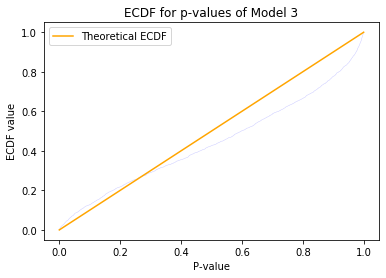

In [52]:
x,y = ecdf(p_values)
plt.plot(x,y, alpha=0.2, linewidth=0.5, color='blue')

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

In [53]:
path = './dep/Station182'
data_files = os.listdir(path)
n_weeks = len(data_files)
bike_data = {file: pd.read_csv(path + '/' + file)
             for file in data_files}        

for names in bike_data.keys():
    del bike_data[names]["Unnamed: 0"]
    
bike_data.keys()

dict_keys(['235_07Oct2020-13Oct2020.csv', '234_30Sep2020-06Oct2020.csv', '222_08Jul2020-14Jul2020.csv', '227_12Aug2020-18Aug2020.csv', '224_22Jul2020-28Jul2020.csv', '226_05Aug2020-11Aug2020.csv', '232_16Sep2020-22Sep2020.csv', '228_19Aug2020-25Aug2020.csv', '236_14Oct2020-20Oct2020.csv', '221_01Jul2020-07Jul2020.csv', '231_09Sep2020-15Sep2020.csv', '225_29Jul2020-04Aug2020.csv', '223_15Jul2020-21Jul2020.csv', '233_23Sep2020-29Sep2020.csv', '230_02Sep2020-08Sep2020.csv', '229_26Aug2020-01Sep2020.csv'])

In [54]:
dep_times = {}

for names in bike_data.keys():
    if names != '.DS_Store':
        df = bike_data[names]
        df = df['start_t']
        dep_times[names] = df.values.tolist()
 
dep_times_list = np.array(sorted(flatten(list(dep_times.values()))))
dep_times_list

array([788131.72298713, 788133.52539743, 788192.02634864, ...,
       948795.03118528, 948863.46354042, 948909.92711799])

In [62]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle

 final_simplex: (array([[ -5.0504089 , -27.37611983, -13.16234511],
       [ -5.0504089 , -27.37613258, -13.16236908],
       [ -5.0504097 , -27.37602368, -13.16232307],
       [ -5.05041079, -27.37611856, -13.16236172]]), array([12406.12336532, 12406.12336532, 12406.12336532, 12406.12336532]))
           fun: 12406.12336531677
       message: 'Optimization terminated successfully.'
          nfev: 250
           nit: 136
        status: 0
       success: True
             x: array([ -5.0504089 , -27.37611983, -13.16234511])

In [63]:
beta, theta, lambda_b = np.exp(mle.x[0]), np.exp(mle.x[0]) + np.exp(mle.x[1]), np.exp(mle.x[2])

compensator_t = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t[i+1] = hawkes_comp(t0[i], t0, beta, theta, lambda_b)

inter_arr_times = np.diff(compensator_t)
p_values = np.exp(-inter_arr_times)

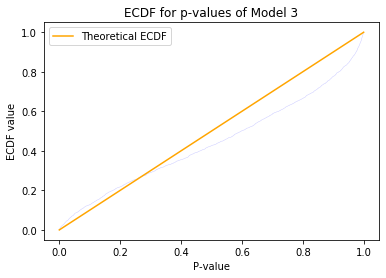

In [64]:
x,y = ecdf(p_values)
plt.plot(x,y, alpha=0.2, linewidth=0.5, color='blue')

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()